# Climate Data Analysis with Parsl and TaskVine

This notebook demonstrates distributed climate data processing using:
- **Parsl**: Parallel programming library for Python
- **TaskVine**: High-throughput distributed computing framework
- **NOAA Global Summary of the Month**: Temperature data from weather stations worldwide

## Objectives:
1. Process temperature data from multiple weather stations in parallel
2. Calculate temperature anomalies relative to 1991-2020 baseline
3. Analyze long-term temperature trends across regions
4. Visualize climate patterns and trends

## Data Source:
NOAA Global Summary of the Month (GSOM) provides monthly climate summaries from weather stations globally. Each CSV file represents one weather station with columns:
- `STATION`: Weather station ID
- `DATE`: Year-month date
- `TAVG`: Average temperature (tenths of degrees Celsius)
- `TMAX`/`TMIN`: Maximum/minimum temperatures

**Note**: Temperatures are stored in tenths of degrees Celsius and converted to Celsius during processing.

# Imports and Configuration

In [1]:
MAX_FILES = 200
DATA_SOURCE_JSON = "data_source.json"

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import parsl
from parsl import python_app
from parsl.config import Config
from parsl.executors.taskvine import TaskVineExecutor
from parsl.executors.taskvine import TaskVineManagerConfig
from parsl.data_provider.files import File
from concurrent.futures import as_completed
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("All imports successful!")

All imports successful!


In [3]:
manager_name = os.environ.get("VINE_MANAGER_NAME", "climate_trend")

config = Config(
    executors=[
        TaskVineExecutor(
            manager_config=TaskVineManagerConfig(
                port=0, 
                project_name=manager_name,
            ),
            worker_launch_method="manual",
        ),
    ]
)
print(f"Manager Name: {manager_name}")

Manager Name: floability-93823ad4-bb35-4a3b-83d2-5c73379b36ff


# Parsl Application Definitions

In [4]:
# Parsl Apps for Climate Data Processing

@python_app
def load_and_clean_data_from_url(csv_url, inputs=[], outputs=[]):
    """Load CSV file and perform basic cleaning"""
    import pandas as pd
    import numpy as np
    
    try:
        # Read NOAA Global Summary of the Month data from url
        df = pd.read_csv(csv_url)
        df['DATE'] = pd.to_datetime(df['DATE'])
        
        # Check for temperature columns and convert from tenths to degrees Celsius
        temp_cols = ['TAVG', 'TMAX', 'TMIN']
        available_temp_cols = [col for col in temp_cols if col in df.columns]
        
        if not available_temp_cols:
            return {'file': str(outputs[0]), 'error': 'No temperature columns found'}
        
        # Convert from tenths of degrees to degrees Celsius
        for col in available_temp_cols:
            df[col] = df[col] / 10.0
        
        # Remove rows with missing primary temperature data
        primary_temp_col = 'TAVG' if 'TAVG' in df.columns else available_temp_cols[0]
        df = df.dropna(subset=[primary_temp_col])
        
        # Get station info
        station_id = df['STATION'].iloc[0] if 'STATION' in df.columns and len(df) > 0 else 'Unknown'
        
        # Save cleaned data
        df.to_csv(outputs[0], index=False)
        
        return {
            'file': str(outputs[0]),
            'station_id': station_id,
            'rows': len(df),
            'temp_columns': available_temp_cols,
            'date_range': [str(df['DATE'].min()), str(df['DATE'].max())] if len(df) > 0 else None
        }
    except Exception as e:
        return {'file': str(outputs[0]), 'error': str(e)}

@python_app
def calculate_monthly_anomalies(baseline_start, baseline_end, inputs=[], outputs=[]):
    """Calculate temperature anomalies relative to baseline period"""
    import pandas as pd
    import numpy as np
    
    try:
        df = pd.read_csv(inputs[0])
        df['DATE'] = pd.to_datetime(df['DATE'])
        
        # Find temperature column (prefer TAVG)
        temp_col = 'TAVG' if 'TAVG' in df.columns else ('TMAX' if 'TMAX' in df.columns else 'TMIN')
        
        if temp_col not in df.columns:
            return {'file': str(inputs[0]), 'error': 'No temperature column found'}
        
        # Add temporal columns
        df['MONTH'] = df['DATE'].dt.month
        df['YEAR'] = df['DATE'].dt.year
        
        # Calculate baseline climatology
        baseline_data = df[(df['YEAR'] >= baseline_start) & (df['YEAR'] <= baseline_end)]
        if len(baseline_data) == 0:
            return {'file': str(inputs[0]), 'error': f'No data in baseline period {baseline_start}-{baseline_end}'}
        
        baseline_monthly = baseline_data.groupby('MONTH')[temp_col].mean().to_dict()
        
        # Calculate anomalies
        df['TEMP_ANOMALY'] = df.apply(
            lambda row: row[temp_col] - baseline_monthly.get(row['MONTH'], np.nan), axis=1
        )
        
        # Save results
        result_df = df[['DATE', 'YEAR', 'MONTH', temp_col, 'TEMP_ANOMALY']].copy()
        result_df.to_csv(outputs[0], index=False)
        
        return {
            'file': str(inputs[0]),
            'processed_records': len(result_df),
            'baseline_years': len(baseline_data['YEAR'].unique()),
            'anomaly_stats': {
                'mean': float(result_df['TEMP_ANOMALY'].mean()),
                'std': float(result_df['TEMP_ANOMALY'].std()),
                'min': float(result_df['TEMP_ANOMALY'].min()),
                'max': float(result_df['TEMP_ANOMALY'].max())
            }
        }
    except Exception as e:
        return {'file': str(inputs[0]), 'error': str(e)}

@python_app
def calculate_annual_trends(inputs=[], outputs=[]):
    """Calculate annual temperature trends from processed files"""
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    try:
        all_data = []
        station_info = []
        
        # Combine all processed files
        for input_file in inputs:
            df = pd.read_csv(input_file)
            if len(df) > 0:
                all_data.append(df)
                # Extract station info from filename
                station_id = str(input_file).split('_')[-1].replace('.csv', '')
                station_info.append(station_id)
        
        if not all_data:
            return {'error': 'No valid data files to process'}
        
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])
        
        # Calculate annual means
        annual_data = combined_df.groupby('YEAR').agg({
            'TEMP_ANOMALY': ['mean', 'std', 'count']
        }).round(4)
        
        annual_data.columns = ['ANNUAL_ANOMALY', 'ANNUAL_STD', 'RECORD_COUNT']
        annual_data = annual_data.reset_index()
        
        # Calculate linear trend
        years = annual_data['YEAR'].values
        anomalies = annual_data['ANNUAL_ANOMALY'].values
        
        valid_idx = ~np.isnan(anomalies)
        if np.sum(valid_idx) > 2:
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                years[valid_idx], anomalies[valid_idx]
            )
            
            annual_data['TREND_LINE'] = slope * years + intercept
            
            trend_info = {
                'slope': slope,
                'intercept': intercept,
                'r_squared': r_value**2,
                'p_value': p_value,
                'trend_per_decade': slope * 10,
                'trend_significance': 'significant' if p_value < 0.05 else 'not significant'
            }
        else:
            trend_info = {'error': 'Insufficient data for trend calculation'}
        
        # Save results
        annual_data.to_csv(outputs[0], index=False)
        
        return {
            'processed_years': len(annual_data),
            'year_range': [int(annual_data['YEAR'].min()), int(annual_data['YEAR'].max())],
            'stations_processed': len(station_info),
            'trend_info': trend_info,
            'mean_anomaly': float(annual_data['ANNUAL_ANOMALY'].mean()),
            'total_records': int(annual_data['RECORD_COUNT'].sum())
        }
        
    except Exception as e:
        return {'error': str(e)}

print("Parsl applications defined successfully!")

Parsl applications defined successfully!


In [5]:
%%time
import json

def process_all_climate_data(max_files = 10, data_source_json = "data_source.json"):
    """Process all available climate data files"""

    data_source = data_source_json

    if not Path(data_source).exists():
        print(f"❌ Configuration file not found: {config_file}")
        return None, None, None

    with open(data_source, 'r') as f:
        stations = json.load(f)
    
    if max_files and len(stations) > max_files:
        stations = stations[:max_files]

    print(f"Found {len(stations)} stations to process from URLs")
    
    with parsl.load(config):
        print("Parsl configuration loaded - starting distributed processing...")
        
        # Phase 1: Clean all data files
        print(f"\n🔄 Phase 1: Cleaning {len(stations)} data files...")
        cleaning_futures = []
        
        for i, station in enumerate(stations):
            # input_file = File(str(station["url"]))
            output_file = File(f"cleaned_{station['name']}")

            future = load_and_clean_data_from_url(station['url'], inputs=[], outputs=[output_file])
            cleaning_futures.append((future, output_file, station['name']))
        
        # Wait for cleaning with progress bar
        cleaning_results = []
        cleaned_files = []
        
        print("Processing files...")
        for future, output_file, filename in tqdm(cleaning_futures, desc="Cleaning"):
            try:
                result = future.result(timeout=300)
                cleaning_results.append(result)
                
                if 'error' in result:
                    print(f"  ❌ {filename}: {result['error']}")
                else:
                    print(f"  ✅ {filename}: Station {result.get('station_id', 'Unknown')}, {result['rows']} records")
                    cleaned_files.append(output_file)
                    
            except Exception as e:
                print(f"  ❌ {filename}: Processing failed - {e}")
        
        successful_files = len([r for r in cleaning_results if 'error' not in r])
        print(f"\n✅ Phase 1 Complete: {successful_files}/{len(stations)} files cleaned successfully")
        
        if not cleaned_files:
            print("❌ No files were successfully cleaned. Exiting.")
            return None, None, None
        
        # Phase 2: Calculate anomalies
        print(f"\n🔄 Phase 2: Calculating temperature anomalies...")
        anomaly_futures = []
        baseline_start, baseline_end = 1991, 2020
        
        for cleaned_file in cleaned_files:
            output_file = File(f"anomalies_{Path(str(cleaned_file)).name}")
            future = calculate_monthly_anomalies(
                baseline_start, baseline_end,
                inputs=[cleaned_file], outputs=[output_file]
            )
            anomaly_futures.append((future, output_file))
        
        # Wait for anomaly calculations
        anomaly_results = []
        valid_anomaly_files = []
        
        print("Calculating anomalies...")
        for future, output_file in tqdm(anomaly_futures, desc="Anomalies"):
            try:
                result = future.result(timeout=300)
                anomaly_results.append(result)
                
                if 'error' in result:
                    print(f"  ❌ Anomaly calculation failed: {result['error']}")
                else:
                    print(f"  ✅ Processed {result['processed_records']} records, {result['baseline_years']} baseline years")
                    valid_anomaly_files.append(output_file)
                    
            except Exception as e:
                print(f"  ❌ Anomaly calculation failed: {e}")
        
        print(f"\n✅ Phase 2 Complete: {len(valid_anomaly_files)} files with anomalies calculated")
        
        if not valid_anomaly_files:
            print("❌ No anomaly files created. Exiting.")
            return None, None, None
        
        # Phase 3: Calculate trends
        print(f"\n🔄 Phase 3: Calculating long-term trends...")
        trends_output = File("annual_trends_large.csv")
        
        try:
            trend_future = calculate_annual_trends(
                inputs=valid_anomaly_files, outputs=[trends_output]
            )
            
            print("Computing global trends...")
            trend_result = trend_future.result(timeout=600)  # Longer timeout for large dataset
            
            if 'error' in trend_result:
                print(f"❌ Trend calculation error: {trend_result['error']}")
                return cleaning_results, anomaly_results, None
            
            print(f"\n🎉 Processing Complete!")
            print("="*60)
            print(f"📊 Processed {trend_result['stations_processed']} weather stations")
            print(f"📅 Analysis period: {trend_result['year_range'][0]}-{trend_result['year_range'][1]} ({trend_result['processed_years']} years)")
            print(f"📈 Total records: {trend_result['total_records']:,}")
            print(f"🌡️  Mean temperature anomaly: {trend_result['mean_anomaly']:.3f}°C")
            
            if 'trend_info' in trend_result and 'slope' in trend_result['trend_info']:
                trend_info = trend_result['trend_info']
                print(f"📈 Temperature trend: {trend_info['trend_per_decade']:.4f}°C per decade ({trend_info['trend_significance']})")
                print(f"📊 R-squared: {trend_info['r_squared']:.3f}")
                print(f"🔬 P-value: {trend_info['p_value']:.2e}")
            
            print(f"\n💾 Results saved to: annual_trends_large.csv")
            return cleaning_results, anomaly_results, trend_result
            
        except Exception as e:
            print(f"❌ Trend calculation failed: {e}")
            return cleaning_results, anomaly_results, None

# Run the processing pipeline
cleaning_results, anomaly_results, trend_result = process_all_climate_data(max_files = MAX_FILES, data_source_json = DATA_SOURCE_JSON)

Found 200 stations to process from URLs
Parsl configuration loaded - starting distributed processing...

🔄 Phase 1: Cleaning 200 data files...
Processing files...


Cleaning:   0%|          | 0/200 [00:00<?, ?it/s]2025/05/24 08:49:45.15 vine_manager[883094]notice: Cannot stat file file-rnd-fnasoujlqrfoiaz(cleaned_AM000037782.csv): No such file or directory
2025/05/24 08:49:45.21 vine_manager[883094]notice: Cannot stat file file-rnd-esduhxpeesrnonl(cleaned_AM000037798.csv): No such file or directory
2025/05/24 08:49:46.10 vine_manager[883094]notice: Cannot stat file file-rnd-zddicyrnwfvyrmy(cleaned_AJ000037636.csv): No such file or directory
2025/05/24 08:49:46.52 vine_manager[883094]notice: Cannot stat file file-rnd-oyuwhhglskuafch(cleaned_ACW00011647.csv): No such file or directory
2025/05/24 08:49:46.81 vine_manager[883094]notice: Cannot stat file file-rnd-lyogybylrxjlucx(cleaned_AM000037708.csv): No such file or directory
2025/05/24 08:49:47.72 vine_manager[883094]notice: Cannot stat file file-rnd-pumdppqpoohevku(cleaned_AM000037700.csv): No such file or directory
2025/05/24 08:49:48.80 vine_manager[883094]notice: Cannot stat file file-rnd-nnkk

  ✅ ACW00011604.csv: Station ACW00011604, 7 records
  ❌ ACW00011647.csv: No temperature columns found
  ✅ AE000041196.csv: Station AE000041196, 115 records
  ✅ AEM00041194.csv: Station AEM00041194, 29 records


2025/05/24 08:49:57.95 vine_manager[883094]notice: Cannot stat file file-rnd-omdmqsexryhxaxp(cleaned_AJ000037813.csv): No such file or directory
2025/05/24 08:49:58.56 vine_manager[883094]notice: Cannot stat file file-rnd-rbpwbecslyqlbxm(cleaned_AJ000037753.csv): No such file or directory
2025/05/24 08:49:59.65 vine_manager[883094]notice: Cannot stat file file-rnd-ssflhhigaxaymqd(cleaned_AJ000037742.csv): No such file or directory
Cleaning:   2%|▎         | 5/200 [00:59<29:43,  9.14s/it]  

  ✅ AEM00041217.csv: Station AEM00041217, 74 records


2025/05/24 08:50:01.48 vine_manager[883094]notice: Cannot stat file file-rnd-uabahbbrihtlgos(cleaned_AJ000037673.csv): No such file or directory
2025/05/24 08:50:01.95 vine_manager[883094]notice: Cannot stat file file-rnd-dlxicbgtnrxpdik(cleaned_AJ000037639.csv): No such file or directory
Cleaning:   3%|▎         | 6/200 [01:01<23:47,  7.36s/it]

  ✅ AEM00041218.csv: Station AEM00041218, 20 records
  ✅ AF000040930.csv: Station AF000040930, 4 records
  ✅ AFM00040938.csv: Station AFM00040938, 4 records
  ✅ AFM00040948.csv: Station AFM00040948, 2 records
  ✅ AFM00040990.csv: Station AFM00040990, 15 records
  ✅ AG000060390.csv: Station AG000060390, 714 records
  ✅ AG000060590.csv: Station AG000060590, 775 records
  ✅ AG000060611.csv: Station AG000060611, 552 records


2025/05/24 08:50:03.26 vine_manager[883094]notice: Cannot stat file file-rnd-cizckhrtmkgubhu(cleaned_AM000037785.csv): No such file or directory
Cleaning:   7%|▋         | 14/200 [01:01<06:19,  2.04s/it]

  ✅ AG000060680.csv: Station AG000060680, 751 records
  ✅ AGE00135039.csv: Station AGE00135039, 626 records
  ✅ AGE00147704.csv: Station AGE00147704, 248 records
  ✅ AGE00147705.csv: Station AGE00147705, 527 records
  ✅ AGE00147706.csv: Station AGE00147706, 242 records
  ✅ AGE00147707.csv: Station AGE00147707, 24 records
  ✅ AGE00147708.csv: Station AGE00147708, 595 records
  ✅ AGE00147709.csv: Station AGE00147709, 543 records
  ✅ AGE00147710.csv: Station AGE00147710, 180 records
  ✅ AGE00147711.csv: Station AGE00147711, 310 records
  ✅ AGE00147712.csv: Station AGE00147712, 436 records
  ✅ AGE00147713.csv: Station AGE00147713, 378 records
  ✅ AGE00147714.csv: Station AGE00147714, 183 records
  ✅ AGE00147715.csv: Station AGE00147715, 281 records
  ✅ AGE00147716.csv: Station AGE00147716, 583 records
  ✅ AGE00147717.csv: Station AGE00147717, 459 records
  ✅ AGE00147718.csv: Station AGE00147718, 648 records
  ✅ AGE00147719.csv: Station AGE00147719, 350 records
  ✅ AGE00147720.csv: Station 

2025/05/24 08:50:04.21 vine_manager[883094]notice: Cannot stat file file-rnd-jdabzpdpyyjmhar(cleaned_AJ000037729.csv): No such file or directory
2025/05/24 08:50:04.30 vine_manager[883094]notice: Cannot stat file file-rnd-tmgcmnezqbdzdnd(cleaned_AM000037706.csv): No such file or directory
2025/05/24 08:50:04.71 vine_manager[883094]notice: Cannot stat file file-rnd-udurqthxkdwnszw(cleaned_AM000037695.csv): No such file or directory
2025/05/24 08:50:04.95 vine_manager[883094]notice: Cannot stat file file-rnd-hocsepyhfiefwds(cleaned_AM000037693.csv): No such file or directory
2025/05/24 08:50:05.31 vine_manager[883094]notice: Cannot stat file file-rnd-epdiuqyzjcbxjpd(cleaned_AM000037627.csv): No such file or directory
2025/05/24 08:50:05.40 vine_manager[883094]notice: Cannot stat file file-rnd-aqyphvxlykqceij(cleaned_AM000037609.csv): No such file or directory
2025/05/24 08:50:06.17 vine_manager[883094]notice: Cannot stat file file-rnd-bbcbcescxppczrn(cleaned_AJ000037981.csv): No such fil

  ✅ AGM00060430.csv: Station AGM00060430, 260 records


2025/05/24 08:50:11.07 vine_manager[883094]notice: Cannot stat file file-rnd-hkikyzbwcqapgbp(cleaned_AJ000037605.csv): No such file or directory
2025/05/24 08:50:11.26 vine_manager[883094]notice: Cannot stat file file-rnd-izplyoguwuxnvwf(cleaned_AM000037786.csv): No such file or directory
2025/05/24 08:50:11.35 vine_manager[883094]notice: Cannot stat file file-rnd-rywemqrshiewkcu(cleaned_AJ000037835.csv): No such file or directory
2025/05/24 08:50:11.66 vine_manager[883094]notice: Cannot stat file file-rnd-gmxmvebzqbbftdl(cleaned_AM000037713.csv): No such file or directory
2025/05/24 08:50:11.73 vine_manager[883094]notice: Cannot stat file file-rnd-nnumnuttyyaqvih(cleaned_AM000037705.csv): No such file or directory
2025/05/24 08:50:12.09 vine_manager[883094]notice: Cannot stat file file-rnd-ahepyukxwwaflig(cleaned_AM000037689.csv): No such file or directory
2025/05/24 08:50:12.42 vine_manager[883094]notice: Cannot stat file file-rnd-xsbpkutovpvzhwt(cleaned_AM000037608.csv): No such fil

  ✅ AGM00060437.csv: Station AGM00060437, 131 records
  ✅ AGM00060444.csv: Station AGM00060444, 259 records
  ✅ AGM00060445.csv: Station AGM00060445, 151 records
  ✅ AGM00060452.csv: Station AGM00060452, 123 records
  ✅ AGM00060457.csv: Station AGM00060457, 149 records
  ✅ AGM00060461.csv: Station AGM00060461, 75 records
  ✅ AGM00060467.csv: Station AGM00060467, 157 records
  ✅ AGM00060468.csv: Station AGM00060468, 119 records
  ✅ AGM00060471.csv: Station AGM00060471, 8 records
  ✅ AGM00060475.csv: Station AGM00060475, 90 records
  ✅ AGM00060476.csv: Station AGM00060476, 4 records
  ✅ AGM00060490.csv: Station AGM00060490, 145 records
  ✅ AGM00060506.csv: Station AGM00060506, 102 records
  ✅ AGM00060507.csv: Station AGM00060507, 42 records
  ✅ AGM00060511.csv: Station AGM00060511, 104 records
  ✅ AGM00060514.csv: Station AGM00060514, 151 records
  ✅ AGM00060515.csv: Station AGM00060515, 63 records
  ✅ AGM00060518.csv: Station AGM00060518, 204 records
  ✅ AGM00060520.csv: Station AGM0006

Anomalies:   1%|          | 1/126 [00:00<01:05,  1.90it/s]

  ❌ Anomaly calculation failed: No data in baseline period 1991-2020


2025/05/24 08:50:19.78 vine_manager[883094]notice: Cannot stat file file-rnd-ayifagkonlkiuwm(anomalies_cleaned_AGE00147717.csv): No such file or directory
2025/05/24 08:50:20.46 vine_manager[883094]notice: Cannot stat file file-rnd-yjskhxkutcyyveq(anomalies_cleaned_AGE00135039.csv): No such file or directory
2025/05/24 08:50:20.83 vine_manager[883094]notice: Cannot stat file file-rnd-xiooxvqzxlqnxrj(anomalies_cleaned_AF000040930.csv): No such file or directory
2025/05/24 08:50:21.20 vine_manager[883094]notice: Cannot stat file file-rnd-dheygqizxtjoird(anomalies_cleaned_AGE00147713.csv): No such file or directory
2025/05/24 08:50:21.48 vine_manager[883094]notice: Cannot stat file file-rnd-epuadfyfkuganbs(anomalies_cleaned_AGE00147714.csv): No such file or directory
2025/05/24 08:50:21.70 vine_manager[883094]notice: Cannot stat file file-rnd-jcqsidtochpcfsa(anomalies_cleaned_AFM00040938.csv): No such file or directory
2025/05/24 08:50:21.94 vine_manager[883094]notice: Cannot stat file fi

  ✅ Processed 115 records, 9 baseline years
  ✅ Processed 29 records, 15 baseline years
  ✅ Processed 74 records, 21 baseline years
  ✅ Processed 20 records, 8 baseline years
  ❌ Anomaly calculation failed: No data in baseline period 1991-2020
  ❌ Anomaly calculation failed: No data in baseline period 1991-2020
  ❌ Anomaly calculation failed: No data in baseline period 1991-2020
  ✅ Processed 15 records, 3 baseline years
  ✅ Processed 714 records, 13 baseline years
  ✅ Processed 775 records, 23 baseline years
  ✅ Processed 552 records, 26 baseline years
  ✅ Processed 751 records, 14 baseline years
  ❌ Anomaly calculation failed: No data in baseline period 1991-2020
  ❌ Anomaly calculation failed: No data in baseline period 1991-2020
  ❌ Anomaly calculation failed: No data in baseline period 1991-2020
  ❌ Anomaly calculation failed: No data in baseline period 1991-2020
  ❌ Anomaly calculation failed: No data in baseline period 1991-2020
  ✅ Processed 595 records, 16 baseline years
  ❌ A

2025/05/24 08:50:26.15 vine_manager[883094]notice: Cannot stat file file-rnd-jisnlrioblghdla(anomalies_cleaned_AJ000037985.csv): No such file or directory
2025/05/24 08:50:26.38 vine_manager[883094]notice: Cannot stat file file-rnd-xvkzysryudmwelx(anomalies_cleaned_AJ000037895.csv): No such file or directory
2025/05/24 08:50:26.57 vine_manager[883094]notice: Cannot stat file file-rnd-qiwtdwqxtgoddlg(anomalies_cleaned_AJ000037759.csv): No such file or directory
2025/05/24 08:50:28.48 vine_manager[883094]notice: Cannot stat file file-rnd-fyakbqlxiljoqfb(anomalies_cleaned_AGE00147794.csv): No such file or directory
Anomalies:  26%|██▌       | 33/126 [00:09<00:21,  4.36it/s]

  ❌ Anomaly calculation failed: No data in baseline period 1991-2020
  ✅ Processed 124 records, 24 baseline years
  ✅ Processed 32 records, 7 baseline years
  ✅ Processed 245 records, 26 baseline years
  ✅ Processed 91 records, 8 baseline years
  ✅ Processed 37 records, 8 baseline years
  ✅ Processed 55 records, 10 baseline years
  ✅ Processed 3 records, 1 baseline years
  ✅ Processed 133 records, 16 baseline years
  ✅ Processed 143 records, 16 baseline years
  ✅ Processed 1 records, 1 baseline years
  ✅ Processed 5 records, 3 baseline years
  ✅ Processed 1 records, 1 baseline years
  ✅ Processed 10 records, 3 baseline years
  ✅ Processed 102 records, 15 baseline years
  ✅ Processed 153 records, 16 baseline years
  ✅ Processed 143 records, 14 baseline years
  ✅ Processed 132 records, 20 baseline years
  ✅ Processed 260 records, 26 baseline years
  ✅ Processed 131 records, 16 baseline years
  ✅ Processed 259 records, 26 baseline years
  ✅ Processed 151 records, 24 baseline years
  ✅ Pro

2025/05/24 08:50:28.85 vine_manager[883094]notice: Cannot stat file file-rnd-ddhaqrtnqatatgu(anomalies_cleaned_AM000037618.csv): No such file or directory
2025/05/24 08:50:29.27 vine_manager[883094]notice: Cannot stat file file-rnd-trcczzqurojrtft(anomalies_cleaned_AJ000037844.csv): No such file or directory
Anomalies:  51%|█████     | 64/126 [00:10<00:07,  8.72it/s]

  ✅ Processed 102 records, 14 baseline years
  ✅ Processed 42 records, 6 baseline years
  ✅ Processed 104 records, 24 baseline years
  ✅ Processed 151 records, 16 baseline years
  ✅ Processed 63 records, 18 baseline years


Anomalies:  55%|█████▍    | 69/126 [00:11<00:06,  8.39it/s]

  ✅ Processed 204 records, 24 baseline years
  ✅ Processed 173 records, 16 baseline years
  ✅ Processed 181 records, 15 baseline years
  ✅ Processed 66 records, 4 baseline years
  ✅ Processed 311 records, 25 baseline years
  ✅ Processed 171 records, 16 baseline years
  ✅ Processed 147 records, 16 baseline years
  ✅ Processed 99 records, 18 baseline years


2025/05/24 08:50:31.09 vine_manager[883094]notice: Cannot stat file file-rnd-jqbtypgtxhomraq(anomalies_cleaned_AJ000037936.csv): No such file or directory
Anomalies:  61%|██████    | 77/126 [00:11<00:04, 10.10it/s]

  ✅ Processed 276 records, 26 baseline years


2025/05/24 08:50:31.39 vine_manager[883094]notice: Cannot stat file file-rnd-qzugdzwbvgnkoja(anomalies_cleaned_AGM00060690.csv): No such file or directory
Anomalies: 100%|██████████| 126/126 [00:12<00:00, 10.32it/s]


  ✅ Processed 130 records, 24 baseline years
  ✅ Processed 143 records, 14 baseline years
  ✅ Processed 195 records, 20 baseline years
  ✅ Processed 257 records, 26 baseline years
  ✅ Processed 3 records, 3 baseline years
  ✅ Processed 259 records, 23 baseline years
  ✅ Processed 214 records, 11 baseline years
  ✅ Processed 97 records, 16 baseline years
  ✅ Processed 117 records, 21 baseline years
  ✅ Processed 276 records, 26 baseline years
  ✅ Processed 72 records, 9 baseline years
  ✅ Processed 92 records, 19 baseline years
  ✅ Processed 157 records, 24 baseline years
  ✅ Processed 198 records, 14 baseline years
  ✅ Processed 117 records, 19 baseline years
  ✅ Processed 82 records, 18 baseline years
  ✅ Processed 172 records, 26 baseline years
  ❌ Anomaly calculation failed: No data in baseline period 1991-2020
  ✅ Processed 107 records, 4 baseline years
  ✅ Processed 49 records, 8 baseline years
  ✅ Processed 7 records, 2 baseline years
  ✅ Processed 901 records, 4 baseline years
 

## Processing Results

The distributed climate data analysis has completed! Here's what we accomplished:

### Data Processing Pipeline:
1. **Data Cleaning**: Converted NOAA temperature data from tenths of degrees to Celsius, handled missing values
2. **Anomaly Calculation**: Computed temperature anomalies relative to 1991-2020 baseline period
3. **Trend Analysis**: Calculated long-term temperature trends using linear regression

### Key Findings:
- Check the output above for specific statistics including:
  - Number of weather stations processed
  - Time period covered
  - Temperature trend rate (°C per decade)
  - Statistical significance of trends

The following visualizations will explore these results in detail.

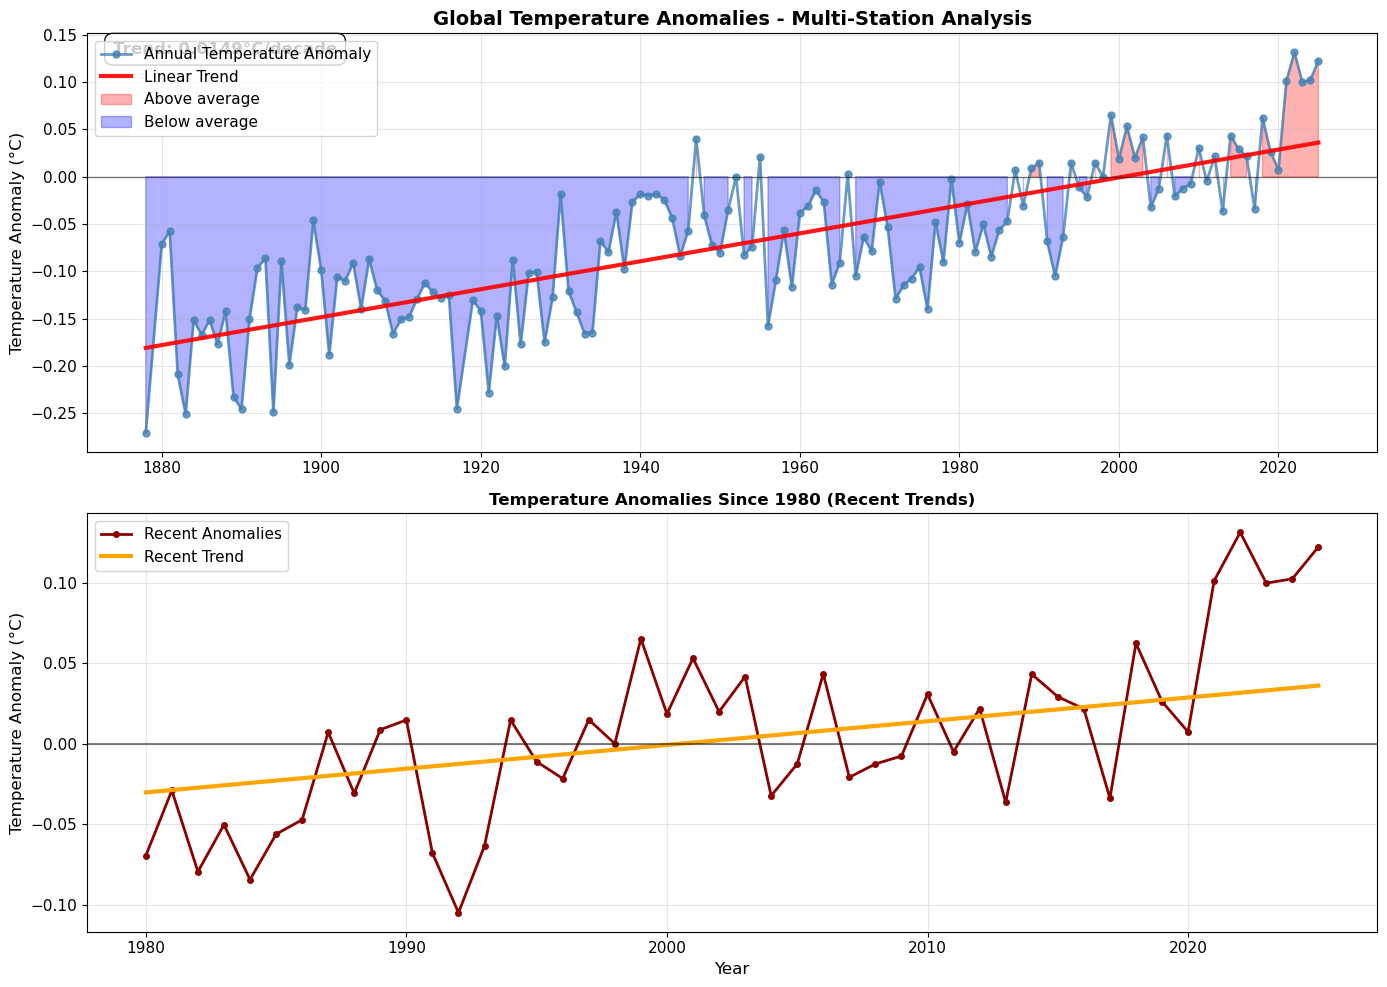

Time series analysis covering 146 years (1878-2025)
Recent warming: 0.005°C average anomaly since 1980


In [6]:
# Load and visualize the large-scale results
df = pd.read_csv("annual_trends_large.csv")

# Create comprehensive time series plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Main time series with trend
ax1.plot(df['YEAR'], df['ANNUAL_ANOMALY'], 'o-', alpha=0.8, linewidth=2, 
         markersize=5, color='steelblue', label='Annual Temperature Anomaly')

if 'TREND_LINE' in df.columns:
    ax1.plot(df['YEAR'], df['TREND_LINE'], 'r-', linewidth=3, 
             label='Linear Trend', alpha=0.9)
    
    # Add trend statistics
    trend_rate = (df['TREND_LINE'].iloc[-1] - df['TREND_LINE'].iloc[0]) / len(df) * 10
    ax1.text(0.02, 0.98, f'Trend: {trend_rate:.4f}°C/decade', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9),
             fontsize=12, fontweight='bold')

# Add reference line and shading
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
ax1.fill_between(df['YEAR'], df['ANNUAL_ANOMALY'], 0, 
                 where=(df['ANNUAL_ANOMALY'] > 0), color='red', alpha=0.3, 
                 label='Above average')
ax1.fill_between(df['YEAR'], df['ANNUAL_ANOMALY'], 0, 
                 where=(df['ANNUAL_ANOMALY'] <= 0), color='blue', alpha=0.3, 
                 label='Below average')

ax1.set_ylabel('Temperature Anomaly (°C)', fontsize=12)
ax1.set_title('Global Temperature Anomalies - Multi-Station Analysis', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

# Zoomed view of recent decades
recent_data = df[df['YEAR'] >= 1980]
ax2.plot(recent_data['YEAR'], recent_data['ANNUAL_ANOMALY'], 'o-', 
         linewidth=2, markersize=4, color='darkred', label='Recent Anomalies')

if 'TREND_LINE' in recent_data.columns:
    ax2.plot(recent_data['YEAR'], recent_data['TREND_LINE'], 'orange', 
             linewidth=3, label='Recent Trend')

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Temperature Anomaly (°C)', fontsize=12)
ax2.set_title('Temperature Anomalies Since 1980 (Recent Trends)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Time series analysis covering {len(df)} years ({df['YEAR'].min()}-{df['YEAR'].max()})")
print(f"Recent warming: {recent_data['ANNUAL_ANOMALY'].mean():.3f}°C average anomaly since 1980")

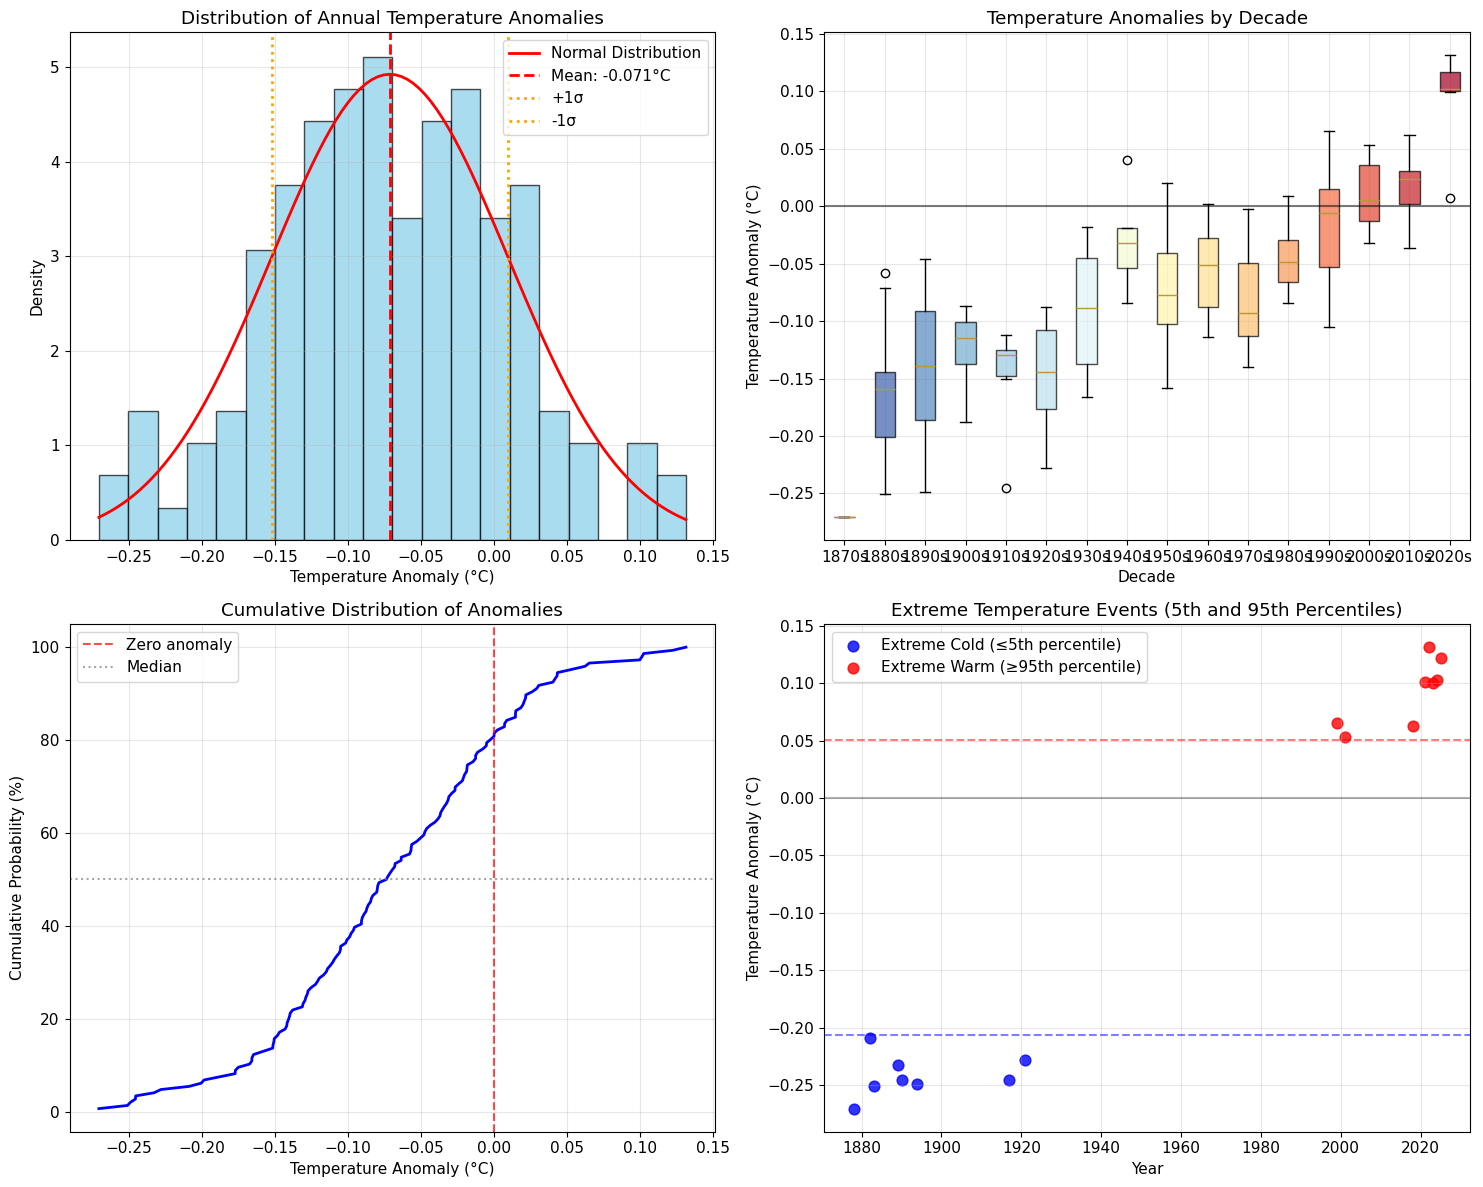

🌡️ EXTREME TEMPERATURE EVENTS
Coldest years (≤5th percentile, -0.207°C):
  1878: -0.271°C
  1883: -0.251°C
  1894: -0.249°C
  1890: -0.245°C
  1917: -0.245°C

Warmest years (≥95th percentile, 0.051°C):
  2022: 0.131°C
  2025: 0.122°C
  2024: 0.102°C
  2021: 0.101°C
  2023: 0.100°C


In [7]:
# Statistical analysis of temperature anomalies
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram with statistical overlay
mean_anomaly = df['ANNUAL_ANOMALY'].mean()
std_anomaly = df['ANNUAL_ANOMALY'].std()

ax1.hist(df['ANNUAL_ANOMALY'], bins=20, density=True, alpha=0.7, 
         color='skyblue', edgecolor='black')

# Overlay normal distribution
x = np.linspace(df['ANNUAL_ANOMALY'].min(), df['ANNUAL_ANOMALY'].max(), 100)
normal_curve = (1/(std_anomaly * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_anomaly)/std_anomaly)**2)
ax1.plot(x, normal_curve, 'r-', linewidth=2, label='Normal Distribution')

ax1.axvline(mean_anomaly, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_anomaly:.3f}°C')
ax1.axvline(mean_anomaly + std_anomaly, color='orange', linestyle=':', linewidth=2, label=f'+1σ')
ax1.axvline(mean_anomaly - std_anomaly, color='orange', linestyle=':', linewidth=2, label=f'-1σ')

ax1.set_xlabel('Temperature Anomaly (°C)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Annual Temperature Anomalies')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot by decade
df['DECADE'] = (df['YEAR'] // 10) * 10
decade_data = [df[df['DECADE'] == decade]['ANNUAL_ANOMALY'].values 
               for decade in sorted(df['DECADE'].unique())]
decade_labels = [f"{int(decade)}s" for decade in sorted(df['DECADE'].unique())]

box_plot = ax2.boxplot(decade_data, labels=decade_labels, patch_artist=True)
colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(box_plot['boxes'])))

for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_xlabel('Decade')
ax2.set_ylabel('Temperature Anomaly (°C)')
ax2.set_title('Temperature Anomalies by Decade')
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution
sorted_anomalies = np.sort(df['ANNUAL_ANOMALY'])
cumulative_prob = np.arange(1, len(sorted_anomalies) + 1) / len(sorted_anomalies)

ax3.plot(sorted_anomalies, cumulative_prob * 100, 'b-', linewidth=2)
ax3.axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero anomaly')
ax3.axhline(50, color='gray', linestyle=':', alpha=0.7, label='Median')

ax3.set_xlabel('Temperature Anomaly (°C)')
ax3.set_ylabel('Cumulative Probability (%)')
ax3.set_title('Cumulative Distribution of Anomalies')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Extreme events analysis
# Calculate percentiles
p5 = np.percentile(df['ANNUAL_ANOMALY'], 5)
p95 = np.percentile(df['ANNUAL_ANOMALY'], 95)

extreme_cold = df[df['ANNUAL_ANOMALY'] <= p5]
extreme_warm = df[df['ANNUAL_ANOMALY'] >= p95]

ax4.scatter(extreme_cold['YEAR'], extreme_cold['ANNUAL_ANOMALY'], 
           color='blue', s=60, alpha=0.8, label=f'Extreme Cold (≤5th percentile)')
ax4.scatter(extreme_warm['YEAR'], extreme_warm['ANNUAL_ANOMALY'], 
           color='red', s=60, alpha=0.8, label=f'Extreme Warm (≥95th percentile)')

ax4.axhline(p5, color='blue', linestyle='--', alpha=0.5)
ax4.axhline(p95, color='red', linestyle='--', alpha=0.5)
ax4.axhline(0, color='black', linestyle='-', alpha=0.3)

ax4.set_xlabel('Year')
ax4.set_ylabel('Temperature Anomaly (°C)')
ax4.set_title('Extreme Temperature Events (5th and 95th Percentiles)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print extreme events summary
print("🌡️ EXTREME TEMPERATURE EVENTS")
print("="*40)
print(f"Coldest years (≤5th percentile, {p5:.3f}°C):")
for _, row in extreme_cold.nsmallest(5, 'ANNUAL_ANOMALY').iterrows():
    print(f"  {int(row['YEAR'])}: {row['ANNUAL_ANOMALY']:.3f}°C")

print(f"\nWarmest years (≥95th percentile, {p95:.3f}°C):")
for _, row in extreme_warm.nlargest(5, 'ANNUAL_ANOMALY').iterrows():
    print(f"  {int(row['YEAR'])}: {row['ANNUAL_ANOMALY']:.3f}°C")

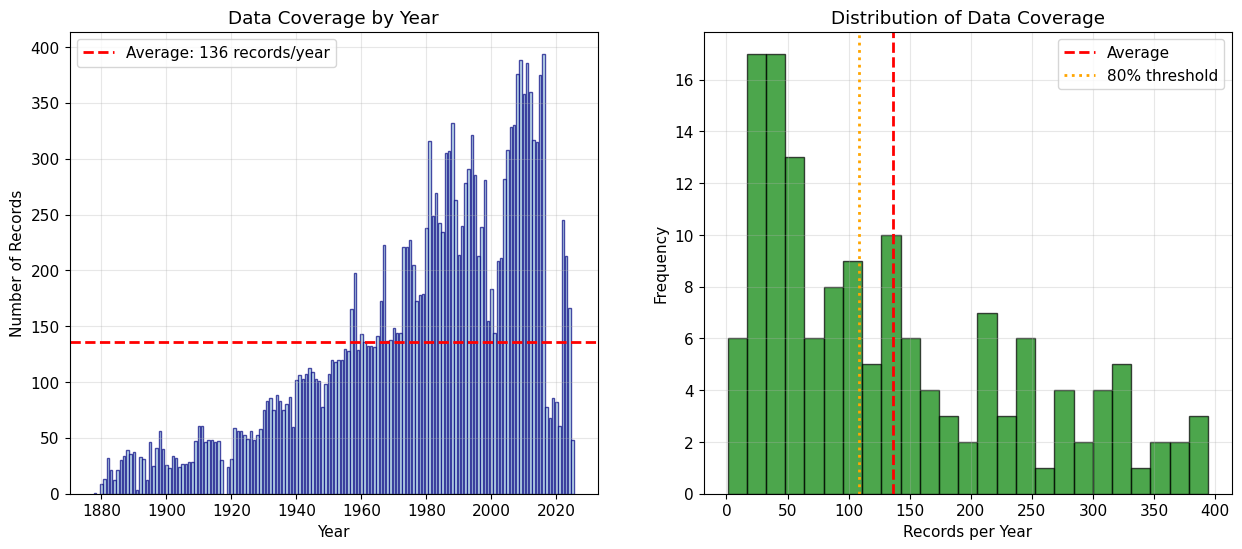

In [8]:
# Analyze data quality and coverage
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Data coverage over time
ax1.bar(df['YEAR'], df['RECORD_COUNT'], alpha=0.7, color='lightblue', edgecolor='navy')
avg_records = df['RECORD_COUNT'].mean()
ax1.axhline(avg_records, color='red', linestyle='--', linewidth=2, 
           label=f'Average: {avg_records:.0f} records/year')

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Records')
ax1.set_title('Data Coverage by Year')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Data quality metrics
quality_years = df['YEAR'][df['RECORD_COUNT'] >= avg_records * 0.8]  # Years with good coverage
ax2.hist(df['RECORD_COUNT'], bins=25, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(avg_records, color='red', linestyle='--', linewidth=2, label='Average')
ax2.axvline(avg_records * 0.8, color='orange', linestyle=':', linewidth=2, 
           label='80% threshold')

ax2.set_xlabel('Records per Year')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Data Coverage')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Optional Cleanup

In [9]:
!rm *.csv